### проект: Исследование самокатчиков

#### Шаг 0. Предмет и задачи исследования
В моём распоряжении три таблицы содержащие данные о пользователях сервиса аренды самокатов, поездках пользователей и информацией о стоимости ежемесячной подписки.

На первом этапе работы я по возможности заполню пропуски, приведу столбцы к правильному типу данных, проведу исследовательский анализ данных, объединю их в один датафрейм и посчитаю выручку.

На втором этапе работы я постараюсь ответить на следующие вопросы бизнеса:
- Тратят ли пользователи с подпиской больше времени на поездки?
- Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
- Проверю снизиться ли количество обращений в тех. поддержку после обновления приложения.
- Посчитаю какое минимальное количество промокодов надо разослать что-бы как минимум 100 клиентов продлили подписку.
- Оценю вероятность того что push-уведомление откроют не более 399.5 тысяч пользователей.

In [1]:
# Необходимые обновления
# !pip install --upgrade matplotlib -q
# !pip install --upgrade pandas -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import math

In [3]:
try:
    users = pd.read_csv('users_go.csv')
    rides = pd.read_csv('rides_go.csv')
    subscriptions = pd.read_csv('subscriptions_go.csv')
except FileNotFoundError:
    users = pd.read_csv('####')
    rides = pd.read_csv('####')
    subscriptions = pd.read_csv('####')

display(users.head())
display(rides.head())
display(subscriptions.head())

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Шаг 1. Загрузка данных

Таблицы успешно загрузились.

In [4]:
# Посмотрим общую информацию о датафреймах
display(users.info())
display(rides.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None

Судя по общей информации о датафреймах пропущенных значений нет. Но некорректно выбран тип столбца date в таблице с поездками.

#### Шаг 2. Предобработка данных

In [5]:
# Преобразуем тип данных столбца date в таблице rides
rides['date'] = rides.date.astype('datetime64[ns]')
rides['month'] = rides.date.dt.month
print(f'minimal_date - {min(rides.date).strftime("%Y-%m-%d")}, maximal date - {max(rides.date).strftime("%Y-%m-%d")}\
, interval - {max(rides.date) - min(rides.date)}')
# Посчитаем % пропущенных значений для наших таблиц
display(pd.DataFrame(round(users.isna().mean()*100,)).style.background_gradient('coolwarm'))
display(pd.DataFrame(round(rides.isna().mean()*100,)).style.background_gradient('coolwarm'))
# Дубликаты
display(users[users.duplicated(keep=False)].sort_values(by='user_id'))
display(rides[rides.duplicated(keep=False)].sort_values(by='user_id'))
users = users[~users.duplicated()]
rides = rides[~rides.duplicated()]

minimal_date - 2021-01-01, maximal date - 2021-12-30, interval - 363 days 00:00:00


,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000


,0
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000


,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra
...,...,...,...,...,...
1554,1198,Демид,29,Ростов-на-Дону,free
1558,1237,Евгения,23,Тюмень,free
1236,1237,Евгения,23,Тюмень,free
1544,1245,Регина,27,Пятигорск,free


,user_id,distance,duration,date,month


Столбец date конвертирован, столбец месяц создан, пропущенных значений нет, дубликаты удалены. Дубликаты были только в таблице с пользователями, несколько десятков штук. Данные за 363 дня 2021 года.

#### Шаг 3. Исследовательский анализ данных

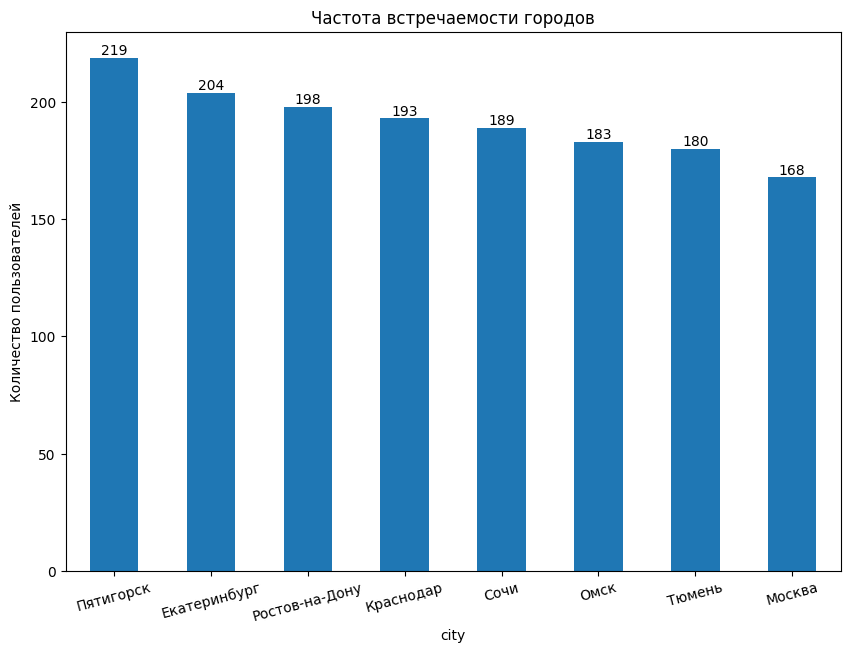

In [6]:
# построим интересующие нас графики
# Частота встречаемости городов
ax = users.city.value_counts().plot(kind='bar', rot=15, title="Частота встречаемости городов",
                                    ylabel='Количество пользователей', figsize=(10, 7))
ax.bar_label(ax.containers[0]);

Распределение по количества пользователей по городам не сильно отличается друг от друга. Больше всего в Пятигорске(219 человек), меньше всего в Москве(168 человек).

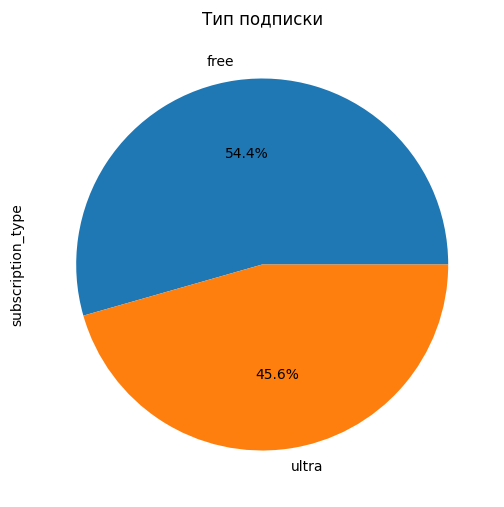

In [7]:
# Тип подписки
ax = users.subscription_type.value_counts().rename('subscription_type').plot(y='subscription_type',
                                                                             kind='pie',
                                                                             title="Тип подписки",
                                                                             autopct='%1.1f%%',
                                                                             figsize=(6, 9))

Доля платных пользователей 45.6%, бесплатных 54.4%.

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

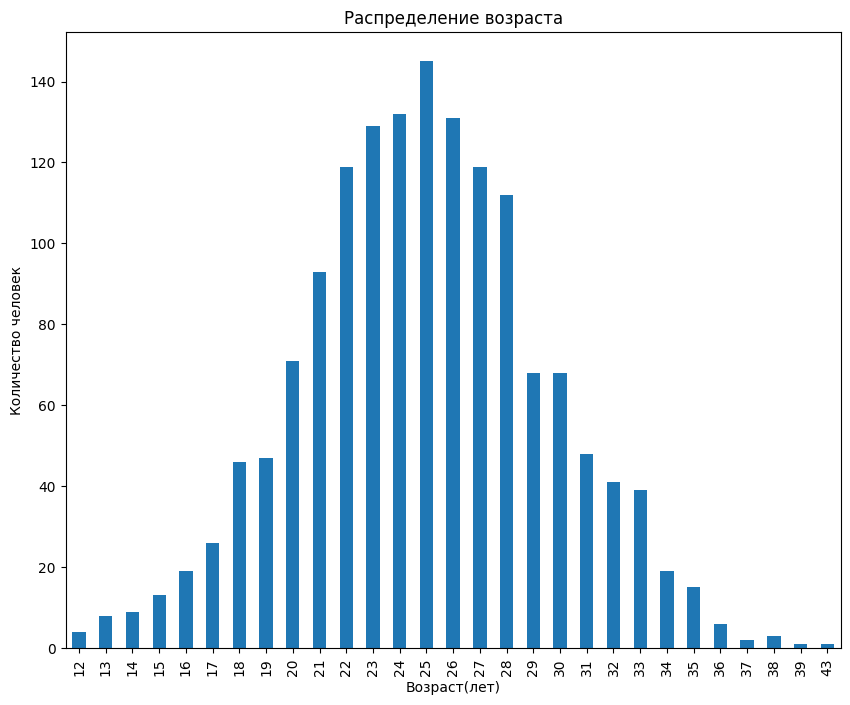

In [8]:
# Распределение возраста
ax = users.age.value_counts().sort_index().plot(kind='bar', title="Распределение возраста", figsize=(10, 8),
                                                xlabel='Возраст(лет)', ylabel='Количество человек')
users.age.describe()

Так как возраст задан дискретно, то решил построить столбиковую диаграмму, что-бы не подбирать оптимальное количество корзин. Средний возраст 24.9, со стандартным отклонением в 4.6 лет. Минимальный возраст 12, максимальный 43. Возраст 50% выборки находится в промежутке между 22 и 28 годами. Распределение близко к нормальному.

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

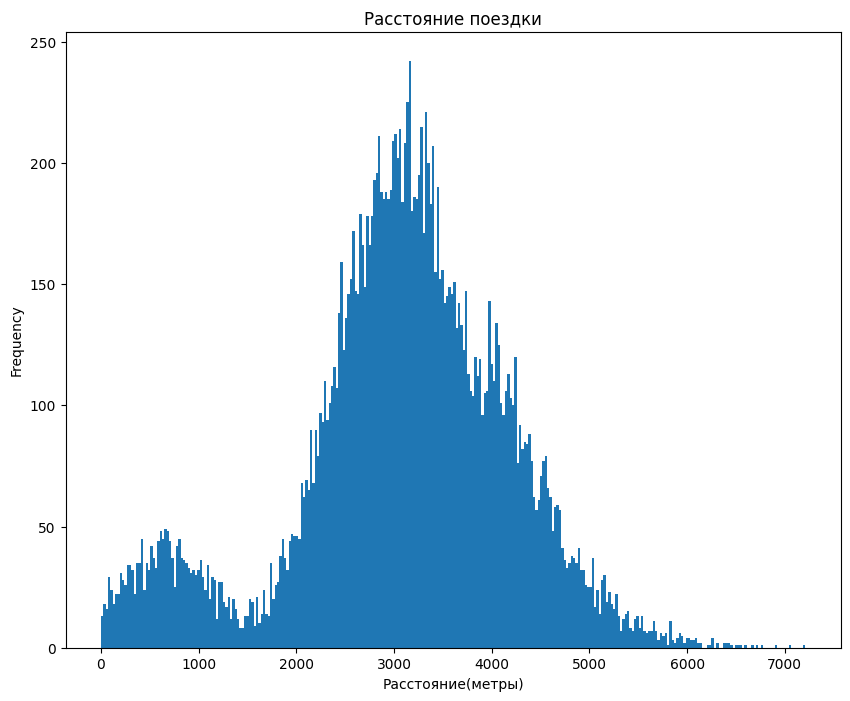

In [9]:
# Расстояние поездки
ax = rides.distance.plot(kind='hist', bins=300, title="Расстояние поездки", figsize=(10, 8))
ax.set_xlabel(xlabel='Расстояние(метры)')
display(rides.distance.describe())

Распределение как будто состоит из двух нормальных. Одна группа использует самокаты что-бы ездить до 1.5 километров, со средним около 800, а другая от 1.5 до 7 км, со средним около 3300. По общей статистике для всей выборки, средняя 3.07 км, стандартное отклонение 1.1 км. Минимальная дистанция 0.8 метра, максимальная 7.211 километров.

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

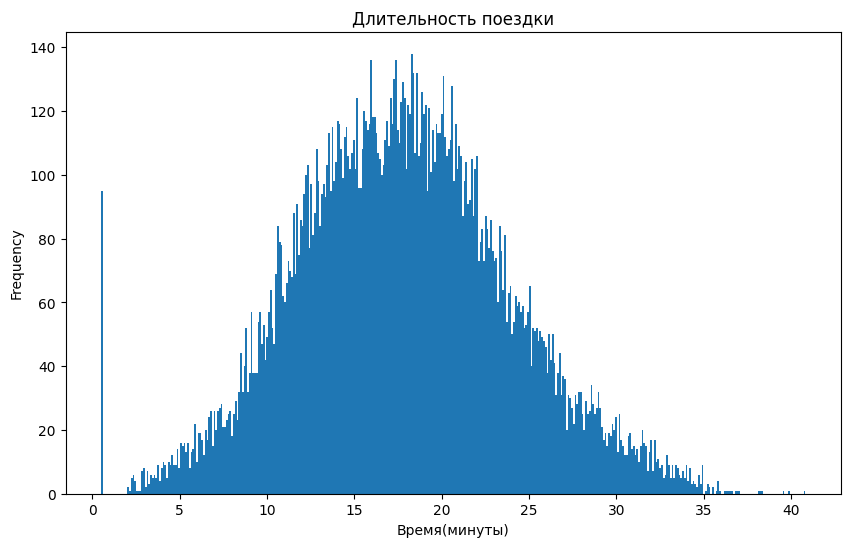

In [10]:
# Длительность поездки
ax = rides.duration.plot(kind='hist', bins=400, title="Длительность поездки", figsize=(10, 6));
ax.set_xlabel('Время(минуты)')
rides.duration.describe()

Среднее время поездки 17.8 минут, стандартное отклонение 6 минут. Минимальное время поездки 0.5 минуты, максимальное 40. Есть большое количество выбросов в районе 1й минуты. Возможно это связано с "малым" горбом на гистограмме расстояния.

Распределение по количества пользователей по городам не сильно отличается друг от друга. Больше всего в Пятигорске(219 человек), меньше всего в Москве(168 человек). Доля платных пользователей 45.6%, бесплатных 54.4%. Средний возраст пользователя 24.9, со стандартным отклонением в 4.6 лет. Минимальный возраст 12, максимальный 43. Возраст 50% выборки находится в промежутке между 22 и 28 годами. Распределение возраста близко к нормальному. Распределение данных по расстоянию поездки как будто состоит из двух нормальных. Одна группа использует самокаты что-бы ездить до 1.5 километров, со средним около 800, а другая от 1.5 до 7 км, со средним около 3300. По общей статистике для всей выборки, средняя 3.07 км, стандартное отклонение 1.1 км. Минимальная дистанция 0.8 метра, максимальная 7.211 километров. Среднее время поездки 17.8 минут, стандартное отклонение 6 минут. Минимальное время поездки 0.5 минуты, максимальное 40. Есть большое количество выбросов в районе 1й минуты. Возможно это связано с "малым" горбом на гистограмме расстояния.

#### Шаг 4. Объединение данных

In [11]:
# Объединение таблиц
df = pd.merge(users, rides, how='left', on='user_id').merge(subscriptions, how='left', on='subscription_type')
print(f'''Размерность:
users - {users.shape}, rides - {rides.shape}, subscriptions - {subscriptions.shape}
должно получиться {rides.shape[0]} строк(join по user_id между users и rides, должно быть равно большей размерности)
и {users.shape[1] + rides.shape[1] + subscriptions.shape[1] - 2} столбцов(два объединения по 'on=', вычитаем 2 столбца из суммы столбцов)
по факту получилось {df.shape[0]} строк и {df.shape[1]} столбцов, выведем первые 5 строк объединённой таблицы''')
display(df.head())
# Поскольку использовался left join проверим не образовалось ли пустых значений (пользователь зарегистрировался и не поехал)
display(pd.DataFrame(round(df.isna().mean()*100)).style.background_gradient('coolwarm'))
# Пустых значений нет
# Разобъем датасет на 2 по признаку подписки
display('Значения подписки:', df.subscription_type.unique())
df_ultra = df[df.subscription_type == 'ultra']
df_free = df[df.subscription_type == 'free']
print(f'Разбив датасет по признаку подписки(ultra/free) получаем две таблицы размерностью {df_ultra.shape}\
 ultra и {df_free.shape} free')
print('Первые 5 строк ultra')
display(df_ultra.head())
print('Первые 5 строк free')
display(df_free.head())

Размерность:
users - (1534, 5), rides - (18068, 5), subscriptions - (2, 4)
должно получиться 18068 строк(join по user_id между users и rides, должно быть равно большей размерности)
и 12 столбцов(два объединения по 'on=', вычитаем 2 столбца из суммы столбцов)
по факту получилось 18068 строк и 12 столбцов, выведем первые 5 строк объединённой таблицы


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000
minute_price,0.000000


'Значения подписки:'

array(['ultra', 'free'], dtype=object)

Разбив датасет по признаку подписки(ultra/free) получаем две таблицы размерностью (6500, 12) ultra и (11568, 12) free
Первые 5 строк ultra


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Первые 5 строк free


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


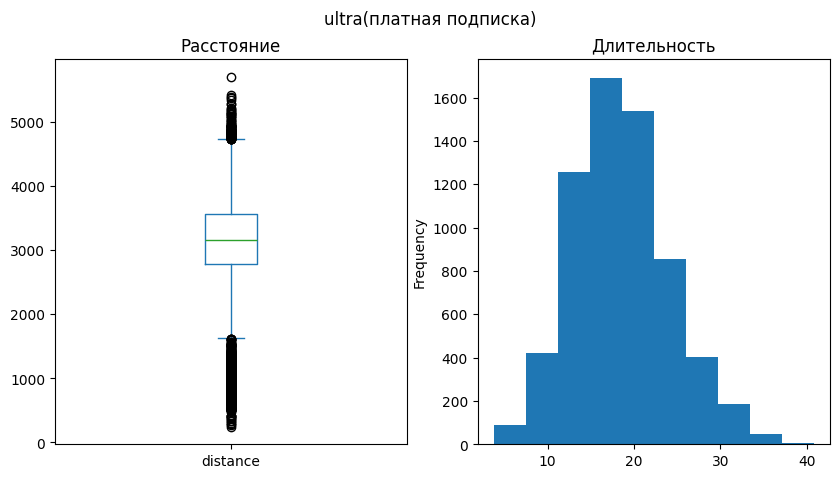

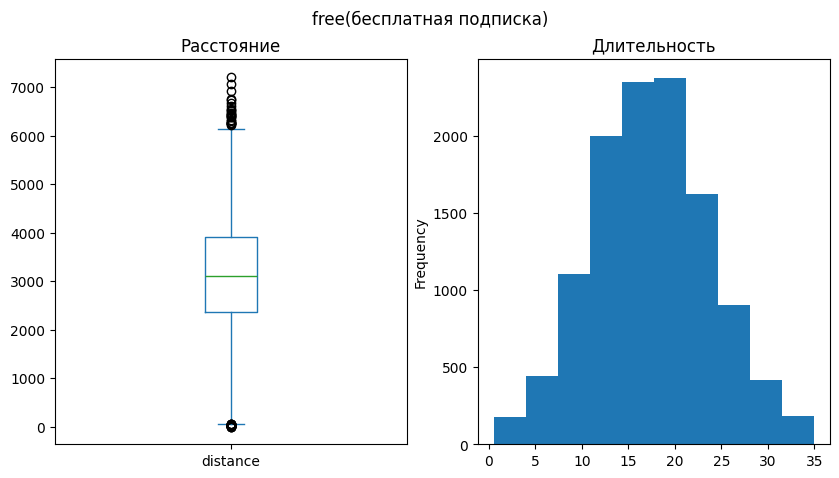

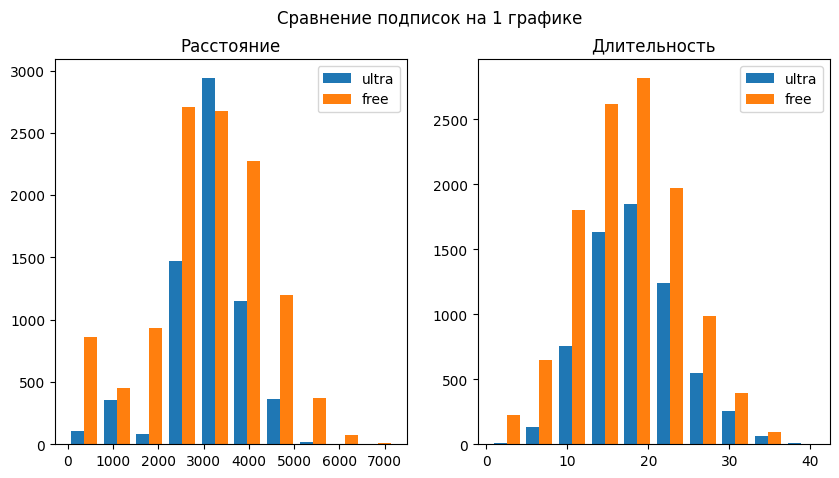

In [12]:
# Визуализируем информацию о расстоянии и времени поездки для созданных групп.
fig, axis = plt.subplots(1, 2 , figsize=(10, 5))
fig.suptitle('ultra(платная подписка)')
df_ultra.distance.plot(kind='box', title='Расстояние', ax=axis[0])
df_ultra.duration.plot(kind='hist', title='Длительность', ax=axis[1]);
fig, axis = plt.subplots(1, 2 , figsize=(10, 5))
fig.suptitle('free(бесплатная подписка)')
df_free.distance.plot(kind='box', title='Расстояние', ax=axis[0])
df_free.duration.plot(kind='hist', title='Длительность', ax=axis[1]);
fig, axis = plt.subplots(1, 2 , figsize=(10, 5))
fig.suptitle('Сравнение подписок на 1 графике')
axis[0].hist([df_ultra.distance, df_free.distance], label=['ultra', 'free'])
axis[0].legend()
axis[0].title.set_text('Расстояние')
axis[1].hist([df_ultra.duration, df_free.duration], label=['ultra', 'free'])
axis[1].legend()
axis[1].title.set_text('Длительность')

Выданные таблицы были объединены в одну, а затем разбиты по признаку подписки. По графикам видно, что пользователи ultra немного чаще ездят на средние расстояния, зато бесплатные пользователи в лидерах по поездкам на 2500, 4000 метров и до 1000 метров. Также по гистограммам можно видеть что у данных похожая дисперсия. Профили пользования самокатом у пользователей разных категорий похожи.

#### Шаг 5. Подсчёт выручки

In [13]:
# Рассчитаем показатели необходимые для расчета выручки
df['duration'] = np.ceil(df.duration)
df_revenue = df.groupby(['month', 'user_id']).agg({'distance': ['sum', 'count'], 'duration': 'sum', 'minute_price': 'first',
                                        'start_ride_price': 'first', 'subscription_fee': 'first',
                                        'subscription_type': 'first'})
df_revenue.columns = ['distance_sum', 'rides_count', 'duration_sum', 'minute_price',
                      'start_ride_price', 'subscription_fee', 'subscription_type']
# Расчитаем выручку для каждого пользователя
df_revenue['user_revenue'] = df_revenue.apply(lambda x: x.start_ride_price * x.rides_count +
                                                       x.minute_price * x.duration_sum + x.subscription_fee, axis=1)
print('Размерность датафрейма', df_revenue.shape)
display(df_revenue.head())

Размерность датафрейма (11331, 8)


distance_sum  rides_count  duration_sum  minute_price  \
month user_id                                                          
1     1         7027.511294            2          42.0             6   
      3         3061.777147            1          13.0             6   
      5         3914.646990            1          13.0             6   
      7         6478.080979            2          28.0             6   
      12        3577.151148            1          33.0             6   

               start_ride_price  subscription_fee subscription_type  \
month user_id                                                         
1     1                       0               199             ultra   
      3                       0               199             ultra   
      5                       0               199             ultra   
      7                       0               199             ultra   
      12                      0               199             ultra   

               user_revenue  
month user_id                
1     1               451.0  
      3               277.0  
      5               277.0  
      7               367.0  
      12              397.0

Выручка для каждого пользователя рассчитана.

#### Шаг 6. Проверка гипотез

In [14]:
# Функция проверки p-value, для всех гипотез выбираю альфа = 0.05
def compare_pval_and_alpha(pval):
    if pval > 0.05:
        print("не могу отвергнуть H_0")
    else:
        print("отвергаем H_0 в пользу H_1")

In [15]:
# Тратят ли пользователи с подпиской больше времени на поездки?
duration = st.ttest_ind(df_ultra.duration, df_free.duration, equal_var=True, alternative='greater')
print(f'P-value = {duration.pvalue:.2e}')
compare_pval_and_alpha(duration.pvalue)
print(f"""
Количество поездок: подписчики - {df_ultra.shape[0]}, простые пользователи - {df_free.shape[0]}
среднее время поездки подписчики - {df_ultra.duration.mean():.2f}
среднее время поездки простые пользователи - {df_free.duration.mean():.2f}
""")
# Попробуем уравнять выборки и заново провести ttest
df_free_sample = df_free.sample(6500, axis=0)
duration = st.ttest_ind(df_ultra.duration, df_free_sample.duration, equal_var=True, alternative='greater')

P-value = 1.28e-34
отвергаем H_0 в пользу H_1

Количество поездок: подписчики - 6500, простые пользователи - 11568
среднее время поездки подписчики - 18.54
среднее время поездки простые пользователи - 17.39


__Гипотеза 6.1__

$H_0$: Пользователи с подпиской и без тратят одинаковое время на дорогу

$H_1$: Пользователи с подпиской тратят больше времени на дорогу

$\alpha$: 0.05

Тратят ли пользователи с подпиской больше времени на поездки? 

Да, вероятность получить значение средней равное или больше, которое мы наблюдали при предположении что средние выборок равны, составляет 1.28e-34, при пороговом 0.05.

Ради интереса попробовал уравнять выборки, случайной выборкой 6500 значений из группы free, после чего
повторить тест. Получил p-value 5.80e-29, альтернативная гипотеза всё равно подтверждается.

In [16]:
# Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, 
# не превышает 3130 метров?
optimal_distance = st.ttest_1samp(df_ultra.distance, 3130, alternative='greater')
print(f'Среднее расстояние за поездку у подписчиков: {df_ultra.distance.mean()}')
print(f'P-value средней при H_0 = {optimal_distance.pvalue:.2}')
compare_pval_and_alpha(optimal_distance.pvalue)

Среднее расстояние за поездку у подписчиков: 3115.4453880370247
P-value средней при H_0 = 0.92
не могу отвергнуть H_0


__Гипотеза 6.2__

$H_0$: Пользователи с подпиской проезжают в среднем 3130 метров за одну поездку

$H_1$: Пользователи с подпиской проезжают в среднем более 3130 метров за одну поездку

$\alpha$: 0.05

Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров? 

Нет, на основании этих данных мы не можем отвергнуть нулевую гипотезу, так как при пороговом значении 0.05 вероятность получить нашу выборочную среднюю равна 0.92, что очень много. Следовательно различия могут быть случайными.

Результирующая таблица с выручкой за месяц по ultra и free пользователям, минимум подсвечен красным


,free_sum,ultra_sum
month,,
1,193850,144108
2,165856,124572
3,187214,142608
4,185598,137318
5,188030,149235
6,192144,143834
7,185038,143466
8,187116,138534
9,193700,129337


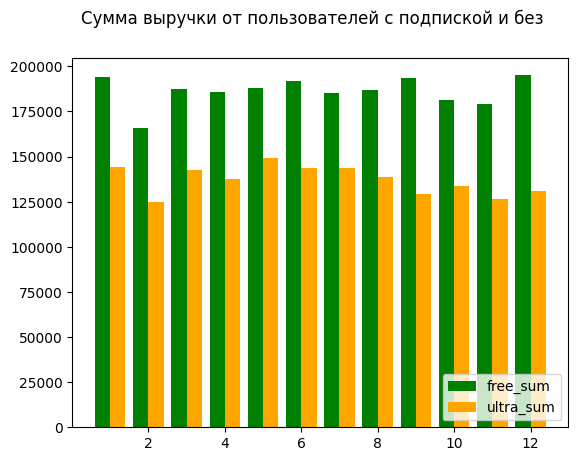

In [17]:
# Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, 
# чем выручка от пользователей без подписки?
# Начнем с рассчета абсолютных значений
# Добавляем столбец цена одной поездки
df['ride_price'] = df.apply(lambda x: x.start_ride_price + x.minute_price * x.duration, axis=1)
"""
Сделаем сводную таблицу, где индексами будут месяцы, а столбцами сумма денег за все поездки free
пользователей, сумма денег за все поездки ultra пользователей и 2 столбца количество уникальных пользователей
умноженое на стоимость подписки для free и ultra, столбец для free получается как побочный эффект
в результате вычислений, я его удалю потом.
"""
price_diff = df.pivot_table(index='month', columns='subscription_type', values=['ride_price', 'user_id'],
                            aggfunc={'ride_price': 'sum', 'user_id': lambda x: x.nunique()*199})
# Переименуем столбцы что-бы не мучаться с мультииндексом
price_diff.columns = ['free_sum', 'ultra_sum', 'free_fees', 'ultra_fees']
# Сложим столбцы ultra_sum и ultra_fees
price_diff['ultra_sum'] = price_diff.ultra_sum + price_diff.ultra_fees
# Удалим не нужные теперь столбцы с подпиской помноженной на количество уников
price_diff.drop(['free_fees', 'ultra_fees'], axis=1, inplace=True)
print(f'Результирующая таблица с выручкой за месяц по ultra и free пользователям, минимум подсвечен красным')
display(price_diff.astype(int).style.highlight_min(axis=1, props='color:red;'))
# Для наглядности построим столбиковую диаграмму
fig, axis = plt.subplots()
fig.suptitle('Сумма выручки от пользователей с подпиской и без')
bar_index = list(price_diff.index)
axis.bar(bar_index, price_diff.free_sum, align = 'edge', width=-0.4, color='green', label='free_sum')
axis.bar(bar_index, price_diff.ultra_sum, align = 'edge', width=0.4, color='orange', label='ultra_sum')
axis.legend(loc='lower right');

Общая статистика за весь период


,free_sum,ultra_sum
count,12.000000,12.000000
mean,186175.333333,137044.750000
std,8106.227385,7919.625888
min,165856.000000,124572.000000
25%,184135.500000,130619.500000
50%,187165.000000,137926.000000
75%,192533.000000,143558.000000
max,195054.000000,149235.000000


% выручки


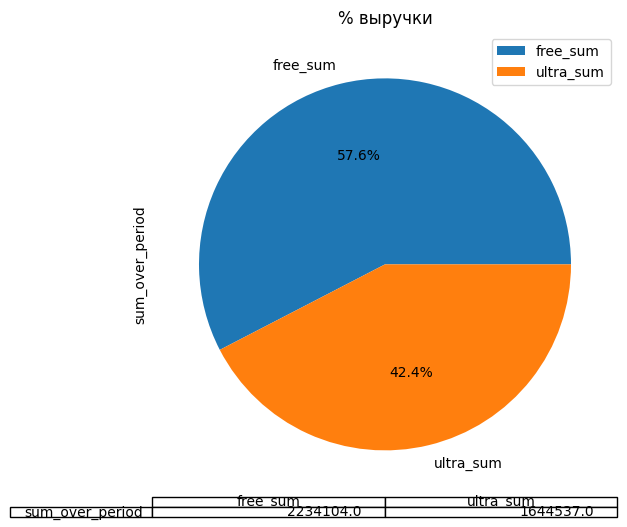

In [18]:
# Выручка по ultra/free за весь период
print('Общая статистика за весь период')
display(price_diff.describe().style.highlight_min(axis=1, props='color:red;'))
# Сумма за весь период
print('% выручки')
price_diff.sum().rename('sum_over_period').plot(y='sum_over_period', kind='pie', title="% выручки",
                                                autopct='%1.1f%%', figsize=(6, 10), legend=True, 
                                                table=True);

In [19]:
df_ultra_monthly_rev = df_revenue[df_revenue['subscription_type']=='ultra']
df_free_monthly_rev = df_revenue[df_revenue['subscription_type']=='free']
print("Проверка нулевой гипотезы, сравниваем выборки по месяцам")
result = st.ttest_ind(df_ultra_monthly_rev.user_revenue, df_free_monthly_rev.user_revenue,
                      alternative='greater')
print(f'p-value = {result.pvalue:.3e}')
compare_pval_and_alpha(result.pvalue)
print("Для интереса, сравним выборки для каждого месяца")
months = dict()
for df_ultra_, df_free_ in zip(df_ultra_monthly_rev.groupby(level=0), df_free_monthly_rev.groupby(level=0)):
    month, df_ultra_ = df_ultra_
    month, df_free_ = df_free_
    result = st.ttest_ind(df_ultra_.user_revenue, df_free_.user_revenue,
                          alternative='greater')
    months[month] = result.pvalue
print("месяц - значение p")
for month, pval in months.items():
    print(f'{month} - {pval:.3e}')
    compare_pval_and_alpha(pval)

Проверка нулевой гипотезы, сравниваем выборки по месяцам
p-value = 1.885e-31
отвергаем H_0 в пользу H_1
Для интереса, сравним выборки для каждого месяца
месяц - значение p
1 - 2.533e-06
отвергаем H_0 в пользу H_1
2 - 1.209e-04
отвергаем H_0 в пользу H_1
3 - 1.073e-02
отвергаем H_0 в пользу H_1
4 - 1.067e-03
отвергаем H_0 в пользу H_1
5 - 3.296e-05
отвергаем H_0 в пользу H_1
6 - 1.771e-04
отвергаем H_0 в пользу H_1
7 - 8.365e-05
отвергаем H_0 в пользу H_1
8 - 2.172e-03
отвергаем H_0 в пользу H_1
9 - 2.163e-03
отвергаем H_0 в пользу H_1
10 - 1.884e-03
отвергаем H_0 в пользу H_1
11 - 1.781e-04
отвергаем H_0 в пользу H_1
12 - 1.211e-03
отвергаем H_0 в пользу H_1


__Гипотеза 6.3__

Из описания задания достоверно не известно генеральная эта совокупность данных или нет, но исходя из малого количества пользователей(1565 человек) предположим что нет. Поэтому начнём с анализа абсолютных данных.
Из сводной таблицы видно что в каждом месяце за 2021 год выручка полученная от группы ultra была ниже чем выручка от группы free. Это более наглядно демонстрирует столбиковая диаграмма. В среднем группа free приносила в месяц 186 тысяч рублей, тогда как ultra 137 тысяч. Выручка за 2021 год которую принесла группа free составила 2.23 миллиона рублей, в то время как ultra только 1.64 миллиона, разница около 15%.

t test

$H_0$: Пользователи с подпиской и без подписки по месяцам приносят одинаковую выручку

$H_1$: Пользователи с подпиской по месяцам приносят большую выручку

$\alpha$: 0.05

По результатам t-test мы с уверенностью отвергаем нулевую гипотезу. P-value сильно меньше 0.05 и равно 1.885e-31.

Дополнительно были проведены тесты для каждого месяца по отдельности, нулевая гипотеза была отвергнута во всех случаях.

__Вывод__ достаточно противоречивый. С одной стороны описательная статистика показывает что пользователи группы free приносят больше денег, но t-test показывает обратное с большой вероятностью.

__Гипотеза 6.4__ 

$H_0$: Количество обращений до и после обновления приложения не изменилось

$H_1$: Количество обращений после обновления приложения снизилось

$\alpha$: 0.05

Для проверки гипотезы необходимо использовать scipy.stats.ttest_rel, потому что у нас парная выборка до и после измерения, одни и те же люди. Также необходимо передать методу параметр alternative='less', для того что-бы проверить левый хвост.

__Вывод__

В задании 6.1 $H_0$ отвергается, пользователи с подпиской тратят больше времени на дорогу. Среднее время поездки у подписчиков - 18.54, а у простых пользователей - 17.39 минут. P-value составляет 1.28e-34, при пороговом 0.05.

В задании 6.2 $H_0$(Пользователи с подпиской проезжают в среднем 3130 метров за одну поездку) не отвергается так как p-value = 0.08, что больше выбранного порогового значения 0.05. Среднее расстояние за поездку у подписчиков: 3114.

В задании 6.3 я сначала посчитал описательную статистику. Из сводной таблицы видно что в каждом месяце за 2021 год выручка полученная от группы ultra была ниже чем выручка от группы free. В среднем группа free приносила в месяц 186 тысяч рублей, тогда как ultra 137 тысяч. Выручка за 2021 год которую принесла группа free составила 2.23 миллиона рублей, в то время как ultra только 1.64 миллиона, разница около 15%.
Затем был проведён t-test c $H_0$: пользователи с подпиской и без подписки по месяцам приносят одинаковую выручку, $H_1$: пользователи с подпиской по месяцам приносят большую выручку и $\alpha$: 0.05. P-value сильно меньше 0.05 и равно 1.885e-31. $H_0$ отвергается. Дополнительно были проведены тесты для каждого месяца по отдельности, нулевая гипотеза была отвергнута во всех случаях.

В задании 6.4 для проверки альтернативной гипотезы о том что количество обращений в поддержку снизилось необходимо использовать scipy.stats.ttest_rel, потому что у нас парная выборка до и после измерения, одни и те же люди. Также необходимо передать методу параметр alternative='less', для того что-бы проверить левый хвост.

Итого статистический тест Стьюдента говорит о том что подписанные пользователи приносят больше выручки. Но в то же время описательная статистика говорит об обратном. Количество подписанных пользователей в выборке на 10% меньше чем обычных, но в то же время, для данной выборки, обычные пользователи приносят 15% больше выручки.

#### Шаг 7. Распределения (Необязательные задачи)

__Задача 1__
Компания GoFast поставила перед отделом маркетинга задачу: необходимо провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. После завершения бесплатного пробного периода пользователь может либо отказаться от подписки, либо продлить её, совершив соответствующий платёж. Ранее проводилась похожая акция, и по итогам выяснилось, что после бесплатного пробного периода подписку продлевают только 10% пользователей.

Необходимо выяснить, сколько промокодов минимально следует разослать, чтобы вероятность не выполнения плана составляла приблизительно 5%. Подберите параметры распределения, описывающего данную ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

Минимально допустимое значение: 1172 промокодов, при этом вероятность не выполнить план 0.04954795210203071


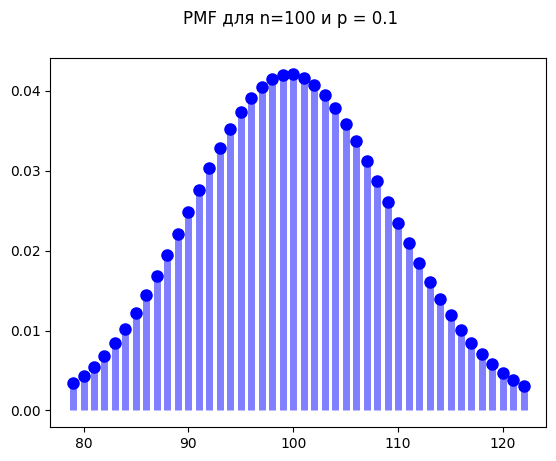

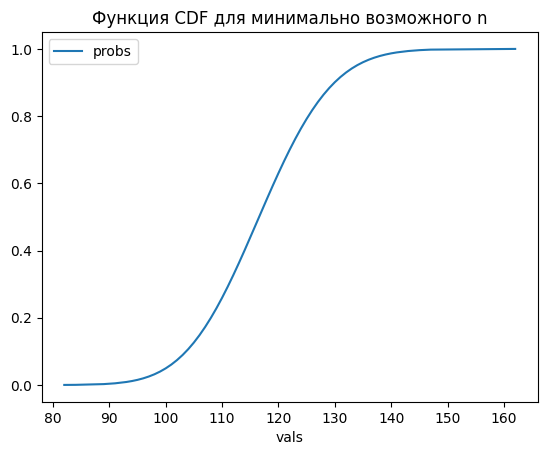

In [20]:
# Стартовая точка вероятность 10% и 1000 испытаний, что-бы среднее было 100
p = 0.1
n = 1000

my_dist = st.binom(n, p)

# Построим график от 1% до 99%
fig, ax = plt.subplots(1, 1)
x = np.arange(my_dist.ppf(0.01),
              my_dist.ppf(0.99))
ax.plot(x, st.binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, st.binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
fig.suptitle('PMF для n=100 и p = 0.1')
# в нашей стартовой точке отсечке в 5% соответствует цифра 85 приглашений
# Попробуем метод перебора
simulation = {n: prob for n, prob in {n: st.binom(n, p).cdf(100) for n in range(1001, 1500)}.items() if prob <= 0.05}
n = next(iter(simulation))
print(f'Минимально допустимое значение: {n} промокодов, при этом вероятность не выполнить план {simulation[n]}')
# Построим график функции cdf
vals = st.binom(1172, 0.1).rvs(size=1000)
probs = st.binom(1172, 0.1).cdf(vals)
to_plot_cdf = pd.DataFrame([pd.Series(vals, name='vals'), pd.Series(probs, name='probs')]).T.sort_values('vals')
to_plot_cdf.plot(x='vals', y='probs', kind='line', title='Функция CDF для минимально возможного n');


В этой задаче я рассчитал минимально допустимое значение количества промокодов, который должен разослать отдел маркетинга для достижения целевого показателя в минимум 100 продлений бесплатной подписки с шансом неудачи в менее чем 5%. Для первоначальной оценки была использована функция PDF, а затем с помощью симуляции функции CDF было подобрано такое число разосланых промокодов что-бы вероятность неудачи была 5 или менее процентов, оно равно 1172. С увеличением числа промокодов вероятность неудачи будет неуклонно снижаться.

__Задача 2__
Отдел маркетинга отправляет push-уведомления клиентам через мобильное приложение. Клиенты могут открывать уведомления или игнорировать их. Известно, что уведомления открывают около 40% получивших клиентов. Планируется отправить 1 миллион уведомлений. С помощью аппроксимации построим примерное распределение и оценим вероятность того, что уведомление откроют не более чем 399,5 тысяч пользователей.

Вероятность того что уведомление откроет не более 399.5 тысяч человек составляет 15.4%


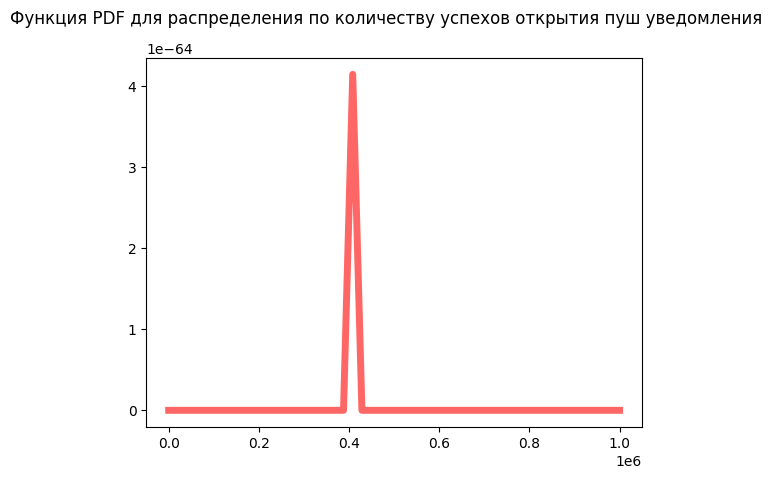

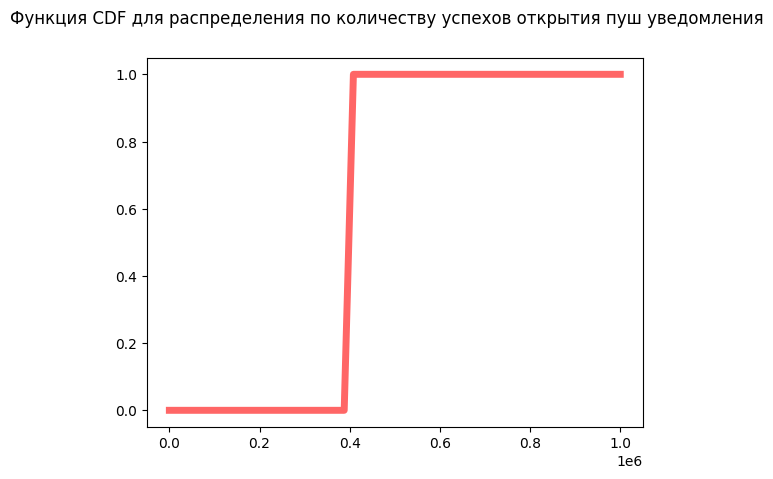

In [21]:
# Условия задачи
n = 1_000_000
p = 0.4
# Построим нормальное распределение на основе данных задачи
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 1_000_000)
ax.plot(x, st.norm.pdf(x, n*p, math.sqrt(n*p*(1-p))), 'r-', lw=5, alpha=0.6)
fig.suptitle('Функция PDF для распределения по количеству успехов открытия пуш уведомления')
fig, ax = plt.subplots(1, 1)
ax.plot(x, st.norm.cdf(x, n*p, math.sqrt(n*p*(1-p))), 'r-', lw=5, alpha=0.6)
fig.suptitle('Функция CDF для распределения по количеству успехов открытия пуш уведомления')

# Рассчитаем вероятность открытия уведомления не более чем 399_500 пользователями
print(f'Вероятность того что уведомление откроет не более 399.5 тысяч человек составляет\
 {st.norm.cdf(399_500, n*p, math.sqrt(n*p*(1-p)))*100:.1f}%')


В этой задаче я оценил вероятность того что пуш уведомление откроют не более 399.5 тысяч пользователей приложения. Исходных данных не было, поэтому работал с предоставленными статистиками n и p. Биномиальное распределение было аппроксимировано нормальным согласно центральной предельной теореме. Были построены графики PDF и CDF нормального распределения, затем при помощи функции CDF была рассчитана вероятность для значения 399500. Таким образом вероятность того что уведомление откроют 399.5 тысяч пользователей или менее составила 15.4%

#### Шаг 8. Вывод

На входе были получены данные об использовании самокатов и 2 дополнительных вопроса. Работа состояла из 3‑х основных этапов:
- очистка, обработка и предварительный анализ полученных данных
- проверка статистических гипотез на очищенных данных
- ответы на дополнительные вопросы

На первом этапе таблицы были проверены на пропущенные значения(которых не оказалось), удалены полные дубликаты, поменяны типы столбцов, где это было необходимо. Добавлен рассчитываемый столбец "месяц". Для общего ознакомления с данным были построены распределения по городам, по возрасту пользователя, по длительности поездки, по дальности поездки и отношение подписанных и не подписанных пользователей. Распределение по количества пользователей по городам не сильно отличается друг от друга. Больше всего в Пятигорске(219 человек), меньше всего в Москве(168 человек). Доля платных пользователей 45.6%, бесплатных 54.4%. Средний возраст 24.9, со стандартным отклонением в 4.6 лет. Минимальный возраст 12, максимальный 43. Возраст 50% выборки находится в промежутке между 22 и 28 годами. Распределение близко к нормальному. Распределение расстояний поездки как будто состоит из двух нормальных. Одна группа использует самокаты что-бы ездить до 1.5 километров, со средним около 800, а другая от 1.5 до 7 км, со средним около 3300. По общей статистике для всей выборки, средняя 3.07 км, стандартное отклонение 1.1 км. Минимальная дистанция 0.8 метра, максимальная 7.211 километров. Среднее время поездки 17.8 минут, стандартное отклонение 6 минут. Минимальное время поездки 0.5 минуты, максимальное 40. Есть большое количество выбросов в районе 1й минуты. Возможно это связано с "малым" горбом на гистограмме расстояния.

Затем выданные таблицы были объединены в одну. Поездки и пользователи по полю 'user_id', а затем объединенная таблица по полю 'subscription_type' с таблицей содержащей цены. Всего в объединённой таблице содержится информация о 1534 пользователях, 18068 поездках и о типе поездки подписки - free/ultra.

После того объединения обогащённая таблица была разбита на 2, по столбцу 'subscription_type', подписан/не подписан. Далее я построил сравнительные графики по этим двум таблицам. По графикам видно, что пользователи ultra немного чаще ездят на средние расстояния, зато бесплатные пользователи в лидерах по поездкам на 2500, 4000 метров и до 1000 метров. Также по гистограммам можно видеть что у данных похожая дисперсия. 

Далее для каждого пользователя была рассчитана выручка по формуле: (стоимость старта поездки × количество поездок) + стоимость одной минуты поездки × общая продолжительность всех поездок в минутах) + стоимость подписки, группировка была по месяцам и id пользователя.

На втором этапе были даны ответы на следующие вопросы:
- Тратят ли пользователи с подпиской больше времени на поездки?
    Да, вероятность получить значение средней равное или больше, которое мы наблюдали при предположении что средние выборок равны, составляет 1.28e-34, при пороговом 0.05.
- Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
    Нет, на основании этих данных мы не можем отвергнуть нулевую гипотезу, так как при пороговом значении 0.05 вероятность получить нашу выборочную среднюю равна 0.08, что больше порогового. Следовательно различия могут быть случайными.
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
    Из описания задания достоверно не известно генеральная эта совокупность данных или нет, но исходя из малого количества пользователей(1565 человек) предположим что нет. Поэтому начнём с анализа абсолютных данных. Из сводной таблицы видно что в каждом месяце за 2021 год выручка полученная от группы ultra была ниже чем выручка от группы free. Это более наглядно демонстрирует столбиковая диаграмма. В среднем группа free приносила в месяц 186 тысяч рублей, тогда как ultra 137 тысяч. Выручка за 2021 год которую принесла группа free составила 2.23 миллиона рублей, в то время как ultra только 1.64 миллиона, разница около 15%. По результатам t-test мы с уверенностью отвергаем нулевую гипотезу, которая говорит о том что помесячная выручка равна в обеих группах. P-value сильно меньше 0.05 и равно 1.885e-31. Дополнительно были проведены тесты для каждого месяца по отдельности, нулевая гипотеза была отвергнута во всех случаях. __Итог__ по вопросу достаточно противоречивый. С одной стороны описательная статистика показывает что пользователи группы free приносят больше денег, но t-test показывает обратное с большой вероятностью.
- Cнизилось ли количество обращений в тех. поддержку после обновления приложения?
    Для проверки гипотезы необходимо использовать scipy.stats.ttest_rel, потому что у нас парная выборка до и после измерения, одни и те же люди. Также необходимо передать методу параметр alternative='less', для того что-бы проверить левый хвост. Поскольку данных нет, то показателей тоже нет.
   
__Общий вывод по предоставленым данным__:

В задании 6.1 $H_0$ отвергается, пользователи с подпиской тратят больше времени на дорогу. Среднее время поездки у подписчиков - 18.54, а у простых пользователей - 17.39 минут. P-value составляет 1.28e-34, при пороговом 0.05.

В задании 6.2 $H_0$(Пользователи с подпиской проезжают в среднем 3130 метров за одну поездку) не отвергается так как p-value = 0.08, что больше выбранного порогового значения 0.05. Среднее расстояние за поездку у подписчиков: 3114.

В задании 6.3 я сначала посчитал описательную статистику. Из сводной таблицы видно что в каждом месяце за 2021 год выручка полученная от группы ultra была ниже чем выручка от группы free. В среднем группа free приносила в месяц 186 тысяч рублей, тогда как ultra 137 тысяч. Выручка за 2021 год которую принесла группа free составила 2.23 миллиона рублей, в то время как ultra только 1.64 миллиона, разница около 15%.
Затем был проведён t-test c $H_0$: пользователи с подпиской и без подписки по месяцам приносят одинаковую выручку, $H_1$: пользователи с подпиской по месяцам приносят большую выручку и $\alpha$: 0.05. P-value сильно меньше 0.05 и равно 1.885e-31. $H_0$ отвергается. Дополнительно были проведены тесты для каждого месяца по отдельности, нулевая гипотеза была отвергнута во всех случаях.

В задании 6.4 для проверки альтернативной гипотезы о том что количество обращений в поддержку снизилось необходимо использовать scipy.stats.ttest_rel, потому что у нас парная выборка до и после измерения, одни и те же люди. Также необходимо передать методу параметр alternative='less', для того что-бы проверить левый хвост.

Итого статистический тест Стьюдента говорит о том что подписанные пользователи приносят больше выручки. Но в то же время описательная статистика говорит об обратном. Количество подписанных пользователей в выборке на 10% меньше чем обычных, но в то же время, для данной выборки, обычные пользователи приносят 15% больше выручки.

__Вывод для бизнеса__:
Случайно выбранный подписчик приносит больше выручки в сравнении со случайно выбранным бесплатным пользователем. Но в тоже время надо учитывать что в абсолютной структуре выручки, возможно, больше денег будут приносить бесплатные пользователи, поскольку их больше. Точнее сказать сложно, поскольку выборки не равны между собой, а именно: количество поездок в таблице rides почти в 2 раза меньше для подписчиков, в таблице users количество бесплатных пользователей на, примерно, 10% больше чем подписчиков.

На третьем этапе были даны ответы на следующие вопросы:
- Какое минимальное количество промокодов надо разослать что-бы как минимум 100 клиентов продлили подписку?
    Я рассчитал минимально допустимое значение количества промокодов, который должен разослать отдел маркетинга для достижения целевого показателя в минимум 100 продлений бесплатной подписки с шансом неудачи в менее чем 5%. Для первоначальной оценки была использована функция PDF, а затем с помощью симуляции функции CDF было подобрано такое число разосланых промокодов что-бы вероятность неудачи была 5 или менее процентов, оно равно 1172. С увеличением числа промокодов вероятность неудачи будет неуклонно снижаться.
- Какова вероятность того что push-уведомление откроют не более 399.5 тысяч пользователей?
    Я оценил вероятность того что пуш уведомление откроют не более 399.5 тысяч пользователей приложения. Исходных данных не было, поэтому работал с предоставленными статистиками n и p. Биномиальное распределение было аппроксимировано нормальным согласно центральной предельной теореме. Были построены графики PDF и CDF нормального распределения, затем при помощи функции CDF была рассчитана вероятность для значения 399500. Таким образом вероятность того что уведомление откроют 399.5 тысяч пользователей или менее составила 15.4%